## MML Week2 Report by Cong Chen
## Preprocess and Find Potential Models

### Play around with data
  - import csv file as pandas dataframe
  - find out important features
  - find out missing values
  - find out mean survavial probability

In [12]:
%%pylab inline
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt

data = pd.read_csv('train.csv') # read training data into a pandas dataframe
data.head(5)    # take a look of the first few lines

Populating the interactive namespace from numpy and matplotlib


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S


In [3]:
data.count()    # possible missing values

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64

In [62]:
Survived = data.Survived
data.groupby('Survived').count()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Survived,,,,,,,,,,,
0,549,549,549,549,424,549,549,549,549,68,549
1,342,342,342,342,290,342,342,342,342,136,340


In [63]:
Survived.mean()
# This is the average survival probability

0.38383838383838381

### Find out numerical features that are important
  - find out numerical features
  - take a look at distribution and values

In [10]:
num_features = pd.DataFrame({'Age':data.Age, 'SibSp':data.SibSp, 'Parch':data.Parch, 'Fare':data.Fare})
# Those are numerical features that are important
print num_features.head(5)

   Age     Fare  Parch  SibSp
0   22   7.2500      0      1
1   38  71.2833      0      1
2   26   7.9250      0      0
3   35  53.1000      0      1
4   35   8.0500      0      0


In [27]:
print 'Possible Parch values:' 
print num_features.Parch.unique()
print
print 'Possible SibSp values:'
print num_features.SibSp.unique()

Age_median = num_features.Age.median()
Age_mean = num_features.Age.mean()

print
print 'Median of Age: %f' %Age_median
print 'Mean of Age: %f' %Age_mean

Possible Parch values:
[0 1 2 5 3 4 6]

Possible SibSp values:
[1 0 3 4 2 5 8]

Median of Age: 28.000000
Mean of Age: 29.699118


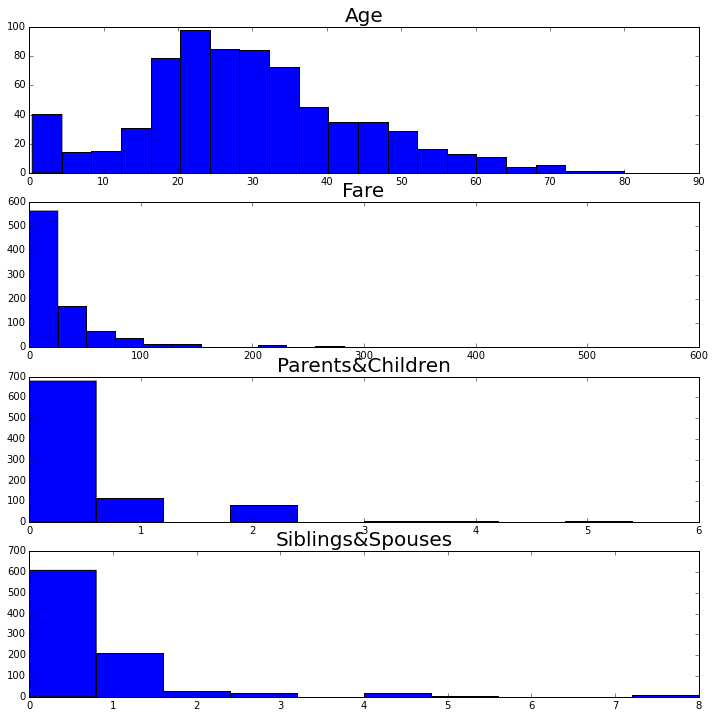

In [37]:
fig1 = plt.figure(figsize=(12,12))
ax1 = fig1.add_subplot(4,1,1)
ax2 = fig1.add_subplot(4,1,2)
ax3 = fig1.add_subplot(4,1,3)
ax4 = fig1.add_subplot(4,1,4)
ax1.hist(num_features.Age.dropna(), bins=20)
ax1.set_title('Age', fontsize=20)
ax2.hist(num_features.Fare, bins=20)
ax2.set_title('Fare', fontsize=20)
ax3.hist(num_features.Parch)
ax3.set_title('Parents&Children', fontsize=20)
ax4.hist(num_features.SibSp)
ax4.set_title('Siblings&Spouses', fontsize=20)



### Find  out catrgorized features that are important
  - find out categorized features that are important
  - convert to dummy variable so we can fit in the model
  - use pandas fillna to fill missing age with median

In [43]:
dis_features = pd.DataFrame({'Sex':data.Sex, 'Embarked':data.Embarked, 'Pclass':data.Pclass})
print dis_features.head(5)
print 
print 'Possible Sex:'
print dis_features.Sex.unique()
print
print 'Possible Embarked:'
print dis_features.Embarked.unique()
print
print 'Possible Pclass:'
print dis_features.Pclass.unique()

  Embarked  Pclass     Sex
0        S       3    male
1        C       1  female
2        S       3  female
3        S       1  female
4        S       3    male

Possible Sex:
['male' 'female']

Possible Embarked:
['S' 'C' 'Q' nan]

Possible Pclass:
[3 1 2]


In [66]:
# We need to convert categorized variable into binary dummy variables.
rich_features = pd.concat([num_features,
                          pd.get_dummies(data['Sex'], prefix='Sex'),
                          pd.get_dummies(data['Pclass'], prefix='Pclass'),
                          pd.get_dummies(data['Embarked'], prefix='Embarked')
                          ], axis=1)
rich_features.drop('Sex_male', axis=1, inplace=True)
rich_features.head(5)


,Age,Fare,Parch,SibSp,Sex_female,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,22,7.2500,0,1,0,0,0,1,0,0,1
1,38,71.2833,0,1,1,1,0,0,1,0,0
2,26,7.9250,0,0,1,0,0,1,0,0,1
3,35,53.1000,0,1,1,1,0,0,0,0,1
4,35,8.0500,0,0,0,0,0,1,0,0,1


In [76]:
Age_median = rich_features.Age.dropna().median()
rich_features.Age = rich_features.Age.fillna(Age_median)
rich_features.Age.count()

891

### Do logistic regression with the features we selected
  - convert features dataframe into numpy arrays so it can work with sklearn
  - split training data into 80/20 training/test set
  - use LogisticRegression from sklearn to fit training data
  - test with test data

In [77]:
from sklearn.cross_validation import train_test_split
features_array = rich_features.values
target = Survived.values

features_train, features_test, target_train, target_test = train_test_split(
    features_array, target, test_size=0.20, random_state=0)



In [79]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C=1)
logreg.fit(features_train, target_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [80]:
predicted = logreg.predict(features_test)

In [81]:
logreg.score(features_test, target_test)
# This is the mean accuracy

0.8044692737430168

### Model Evaluation
  - Take a look at ligistic regression fitting coefficients so we know important features and possible explaination
  - plot confussion matrix, pull out true/false positive/negative rates so we know how our model performs at different ares
  - get classification report from sklearn. Evaluate model throuth precision, recall, f1 number and support
  

In [88]:
feature_names = rich_features.columns.ravel()
coef = logreg.coef_.ravel()
print feature_names
print coef

['Age' 'Fare' 'Parch' 'SibSp' 'Sex_female' 'Pclass_1' 'Pclass_2' 'Pclass_3'
 'Embarked_C' 'Embarked_Q' 'Embarked_S']
[ -4.05630337e-02   2.26102613e-03  -4.72650811e-02  -3.53579090e-01
   2.54846976e+00   1.00133216e+00   1.75343197e-01  -9.52478047e-01
   3.99712209e-02   1.79836425e-01  -2.66411258e-01]


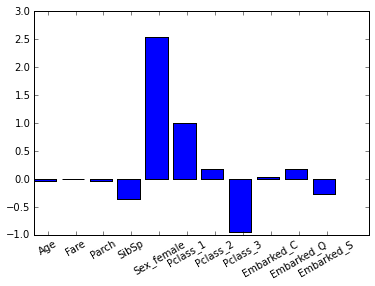

In [89]:
x = np.arange(len(feature_names))
plt.bar(x, coef)
plt.xticks(x + 0.5, feature_names, rotation=30);

In [91]:
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(target_test, predicted)
print confusion

[[93 17]
 [18 51]]


In [111]:
confusion_normed = confusion.astype(float) / confusion.sum(axis=1)[:, np.newaxis]
print confusion_normed

[[ 0.84545455  0.15454545]
 [ 0.26086957  0.73913043]]


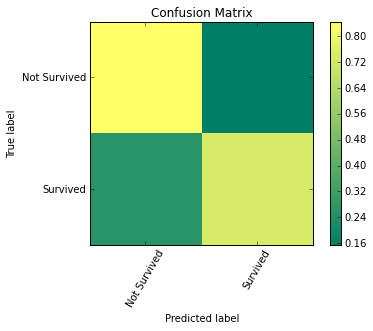

In [112]:
plt.imshow(confusion_normed, interpolation='nearest', cmap=plt.cm.summer)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Not Survived', 'Survived'], rotation=60)
plt.yticks(tick_marks, ['Not Survived', 'Survived'])
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [115]:
from sklearn.metrics import classification_report

print classification_report(target_test, predicted,
                            target_names=['Notot Survived', 'Survived'])

                precision    recall  f1-score   support

Notot Survived       0.84      0.85      0.84       110
      Survived       0.75      0.74      0.74        69

   avg / total       0.80      0.80      0.80       179



## Next: 
  - more evaluation methods
  - cross validation to train parameters
  - try different models